In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2 as cv
import os
from sklearn.cluster import KMeans
import pickle
import pandas as pd
from scipy.spatial.distance import cosine
from sklearn.neighbors import NearestNeighbors
import random

In [2]:
coco_images_dir = "coco128/images/train2017/"

In [3]:
def show_image(img, cmap=None):
    plt.figure(figsize=(15, 9))
    img_to_show = img
    if img.ndim == 3:
        img_to_show = img[:,:,::-1]
    elif cmap is None:
        cmap = "gray"

    if cmap:
        plt.imshow(img_to_show, cmap=cmap)
    else:
        plt.imshow(img_to_show)

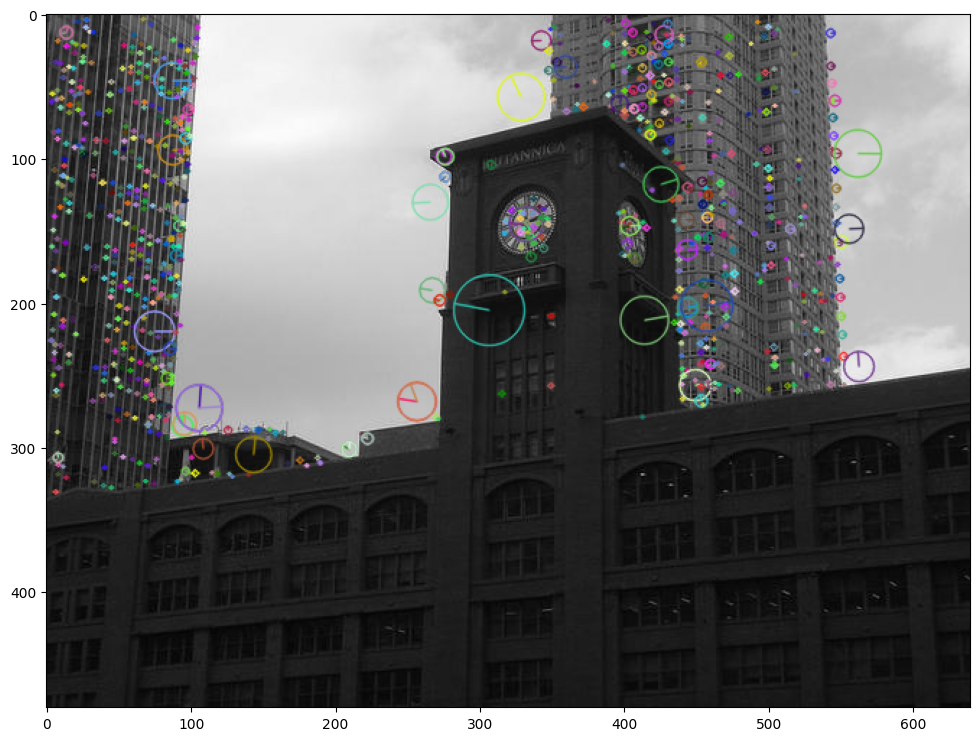

In [4]:
test_path = "000000000626.jpg"
test_path = os.path.join(coco_images_dir, test_path)
test_img = cv.imread(test_path)
gray_img = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp, descriptors = sift.detectAndCompute(gray_img, None)
img = cv.drawKeypoints(gray_img, kp, test_img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_image(img)

In [5]:
descriptors

array([[  0.,   1.,   2., ...,  67.,   1.,   0.],
       [133.,  10.,   0., ...,   0.,   0.,   0.],
       [117.,  24.,   1., ...,   0.,   0.,   1.],
       ...,
       [ 93.,   9.,   1., ...,   1.,  16.,   1.],
       [ 57.,   7.,   0., ...,   0.,   4.,   0.],
       [ 30.,   6.,   1., ...,   1.,   0.,   0.]], dtype=float32)

## Считаем дескрипторы для coco и pascal

In [6]:
sift = cv.SIFT_create()

def get_image_descriptors(gray):
    _, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

In [7]:
def get_descriptors_from_dir(dir):
    descriptors = []
    for filename in os.listdir(dir):
        image_path = os.path.join(dir, filename)
        image = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
        image_descriptors = get_image_descriptors(image)

        if image_descriptors is None or image_descriptors.ndim == 1:
            continue

        descriptors.append(image_descriptors)
    return descriptors

In [8]:
coco_descriptors = get_descriptors_from_dir(coco_images_dir)
coco_descriptors

[array([[ 18.,  24.,  10., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   3.],
        [  7.,  13.,  18., ...,   0.,   0.,   2.],
        ...,
        [  0.,   0.,   0., ...,   1.,   1.,  18.],
        [  3.,  19., 105., ...,   0.,   0.,   3.],
        [ 86.,  38.,   5., ...,   0.,   0.,   0.]], dtype=float32),
 array([[ 13.,  82., 131., ...,   0.,   0.,   0.],
        [ 23.,  59.,  55., ...,  11.,  26.,  25.],
        [  0.,   0.,   0., ...,   1.,   1.,  45.],
        ...,
        [ 12.,   0.,   0., ...,   1.,   0.,   2.],
        [  6.,  36.,  47., ...,   1.,   0.,   0.],
        [ 18.,  90., 121., ...,   0.,   0.,   0.]], dtype=float32),
 array([[12., 10.,  0., ...,  2.,  0.,  0.],
        [ 0.,  0.,  0., ...,  3.,  1.,  6.],
        [ 0.,  3.,  4., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  3.],
        [ 0.,  4.,  5., ...,  6.,  0.,  0.],
        [ 1.,  0., 11., ..., 34., 23., 98.]], dtype=float32),
 array([[27., 40., 56., ...,

In [9]:
def flatten_descriptors(descriptors):
    return np.vstack(descriptors)

In [10]:
coco_descriptors = flatten_descriptors(coco_descriptors)

In [11]:
coco_descriptors.shape

(185453, 128)

## Pascal descriptors

In [12]:
pascal_dir = "pascal"

In [13]:
descriptors = np.load("training_descriptors.npy")
descriptors

array([[ 18.,  24.,  10., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   3.],
       [  7.,  13.,  18., ...,   0.,   0.,   2.],
       ...,
       [  9.,   5.,   3., ...,   3.,   6.,  15.],
       [  0.,   0.,   0., ...,  17., 120.,   3.],
       [ 23.,  85.,  46., ...,   2.,  11.,   8.]], dtype=float32)

In [14]:
descriptors.shape

(385453, 128)

## Обучаем модель K-Means

In [69]:
n_clusters = 2048

In [70]:
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
kmeans.fit(descriptors)

KMeans(n_clusters=2048, n_init='auto', random_state=42)

In [71]:
def save_model_to(model, filename='kmeans.pickle'):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

In [72]:
def load_model_from(filename):
    with open(filename, 'rb') as f:
        model = pickle.load(f)

    return model

In [73]:
save_model_to(kmeans, 'kmeans.pickle')

## Функция для векторизации изображения

In [74]:
def get_normalized_hist(clusters):
    hist_data = np.zeros((n_clusters))
    for cluster in clusters:
        hist_data[cluster] += 1

    hist_data /= clusters.shape[0]

    return hist_data

In [75]:
def vectorize_image_from_file(model, image_file):
    image = cv.imread(image_file, cv.IMREAD_GRAYSCALE)
    descriptors = get_image_descriptors(image)

    if descriptors is None:
        return None
    if descriptors.ndim == 1:
        descriptors = descriptors.reshape(1, -1)

    clusters = model.predict(descriptors)
    hist_data = get_normalized_hist(clusters)
    return hist_data

In [76]:
test_path = "2007_000027.jpg"
test_path = os.path.join(pascal_dir, test_path)
hist_data = vectorize_image_from_file(kmeans, test_path)

<BarContainer object of 2048 artists>

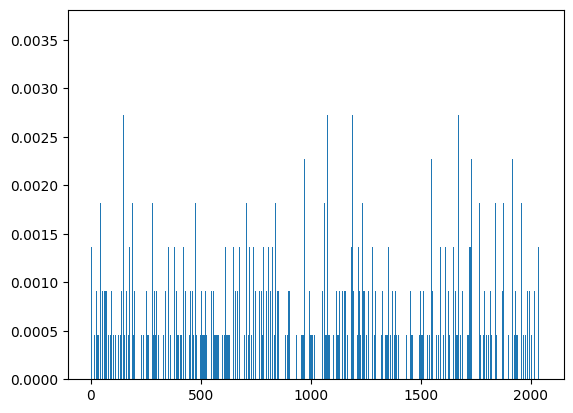

In [77]:
plt.bar(np.arange(n_clusters), hist_data)

In [78]:
np.sum(hist_data)

1.0

In [79]:
import tqdm

In [80]:
def fill_df(model, dir):
    data = pd.DataFrame(columns=["image_path", "vector"])

    files = os.listdir(dir)
    for i in tqdm.tqdm(range(len(files))):
        image_path = os.path.join(dir, files[i])
        hist_data = vectorize_image_from_file(model, image_path)
        if hist_data is not None:
            data.loc[len(data.index)] = [image_path, hist_data]

    return data

In [81]:
data = fill_df(kmeans, pascal_dir)
data

  0%|          | 3/17125 [00:00<10:16, 27.78it/s]

100%|██████████| 17125/17125 [13:07<00:00, 21.76it/s]


,image_path,vector
0,pascal\2007_000027.jpg,"[0.0009078529278256923, 0.00045392646391284613..."
1,pascal\2007_000032.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,pascal\2007_000033.jpg,"[0.0, 0.00631578947368421, 0.0, 0.0, 0.0, 0.0,..."
3,pascal\2007_000039.jpg,"[0.0, 0.002652519893899204, 0.0026525198938992..."
4,pascal\2007_000042.jpg,"[0.0017857142857142857, 0.0017857142857142857,..."
...,...,...
17119,pascal\2012_004326.jpg,"[0.0, 0.0, 0.0, 0.0016611295681063123, 0.00332..."
17120,pascal\2012_004328.jpg,"[0.0, 0.0007751937984496124, 0.000775193798449..."
17121,pascal\2012_004329.jpg,"[0.0, 0.0015360983102918587, 0.0, 0.0, 0.0, 0...."
17122,pascal\2012_004330.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009182736455..."


In [82]:
i = 0
arr = [i for i in range(17125)]
while True:
    if i == 17124:
        break
    if data.index[i] != arr[i]:
        display(data.loc[i])
        break
    i+=1

In [83]:
data.to_csv("image_database.csv")

## Ищем похожие

In [84]:
data["vector"].shape

(17124,)

In [85]:
data["vector"].values

array([array([0.00090785, 0.00045393, 0.00045393, ..., 0.        , 0.00045393,
              0.00136178])                                                    ,
       array([0., 0., 0., ..., 0., 0., 0.]),
       array([0.        , 0.00631579, 0.        , ..., 0.        , 0.        ,
              0.        ])                                                    ,
       ...,
       array([0.       , 0.0015361, 0.       , ..., 0.       , 0.0015361,
              0.       ])                                                ,
       array([0.        , 0.        , 0.        , ..., 0.00091827, 0.        ,
              0.        ])                                                    ,
       array([0.        , 0.        , 0.00275103, ..., 0.00137552, 0.        ,
              0.        ])                                                    ],
      dtype=object)

In [86]:
X = np.vstack(data["vector"].values)
X

array([[0.00090785, 0.00045393, 0.00045393, ..., 0.        , 0.00045393,
        0.00136178],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.00631579, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0015361 , 0.        , ..., 0.        , 0.0015361 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00091827, 0.        ,
        0.        ],
       [0.        , 0.        , 0.00275103, ..., 0.00137552, 0.        ,
        0.        ]])

In [87]:
X.shape

(17124, 2048)

In [88]:
neighbours_model = NearestNeighbors(metric='cosine', algorithm='brute')
neighbours_model.fit(X)

NearestNeighbors(algorithm='brute', metric='cosine')

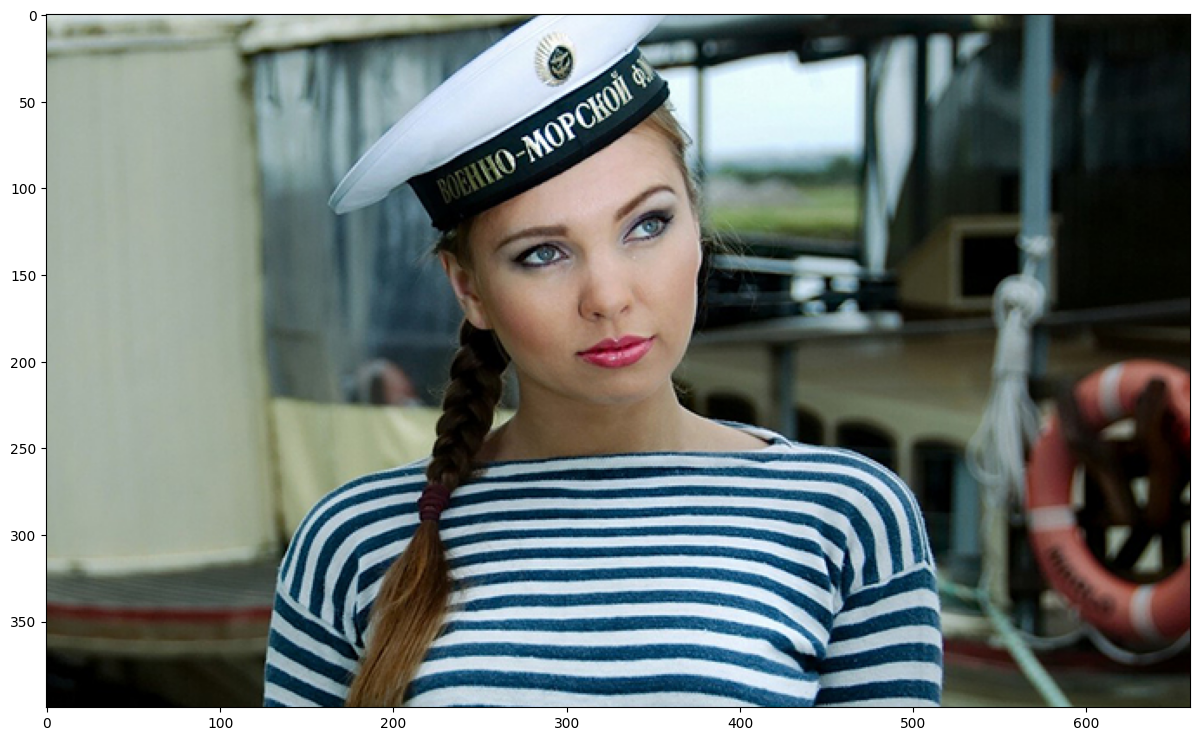

In [130]:
input_filename = "tests/sea_woman.jpg"
input_image = cv.imread(input_filename)
show_image(input_image)

In [131]:
input_vector = vectorize_image_from_file(kmeans, input_filename)
input_vector

array([0., 0., 0., ..., 0., 0., 0.])

In [132]:
distances, indices = neighbours_model.kneighbors([input_vector], n_neighbors=10)
indices[0]

array([ 9836,  1875, 15233, 12561, 14542,     9, 10589,  9816,  5569,
        7216], dtype=int64)

In [133]:
distances[0].max()

0.5855481615314129

In [134]:
pics_pathes = data.loc[indices[0]]["image_path"]
pics_pathes

9836     pascal\2010_004063.jpg
1875     pascal\2008_002255.jpg
15233    pascal\2012_000610.jpg
12561    pascal\2011_002422.jpg
14542    pascal\2011_006382.jpg
9        pascal\2007_000123.jpg
10589    pascal\2010_005556.jpg
9816     pascal\2010_004029.jpg
5569     pascal\2009_000920.jpg
7216     pascal\2009_004129.jpg
Name: image_path, dtype: object

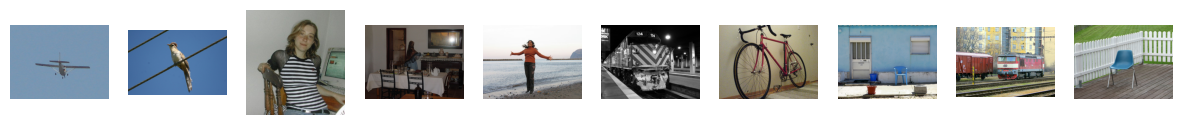

In [135]:
fig, ax = plt.subplots(1, 10, figsize=(15, 10))
for i, image_path in enumerate(pics_pathes):
    img = cv.imread(image_path)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    ax[i].imshow(img)
    ax[i].axis('off')